In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
random = 42

# Basic Exploratory Analysis

In [4]:
def pred(data):
    default_status = []
    for i in train.default_status:
        if i == 'no':
            default_status.append(0)
        else:
            default_status.append(1)
    data['default_status'] = default_status
    return data
train = pred(train)

In [6]:
train.form_field47 = le.fit_transform(train.form_field47).astype(np.uint8)
test.form_field47 = le.fit_transform(test.form_field47).astype(np.uint8)

### Feature Engineering

In [7]:
train['collateral_salary'] = train.form_field15 - train.form_field14
train['credit*risk'] = train['form_field1'] * train['form_field2']

test['collateral_salary'] = test.form_field15 - test.form_field14
test['credit*risk'] = test['form_field1'] * test['form_field2']

In [9]:
X = train.drop(['Applicant_ID', 'default_status'], axis =1)
y = train.default_status

#### Upsampling the data

This method was not that helpful due to little or no sign of improvement i notice it late and decided to stick with

In [10]:
print('Number of class 1 samples before:',X[y == 1].shape[0])

Number of class 1 samples before: 13715


In [11]:
X_upsampled, y_upsampled = resample(X[y == 1],y[y == 1],replace=True,n_samples=X[y == 0].shape[0],random_state=123)
print('Number of class 1 samples after:',X_upsampled.shape[0])

Number of class 1 samples after: 42285


In [12]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify = y_bal, test_size=0.2, random_state=random)

## ML Model 

In [14]:
cat = CatBoostClassifier(iterations=1500)
lgm = LGBMClassifier(n_estimators=1500)

classifier = [lgm,cat]
classifier_names = ['LR','CAT']

In [15]:
def pred (model):
    for i, model in enumerate(classifier):
        model.fit(X_train,y_train)
        pred = model.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test,pred)
        print(f'{classifier_names[i]}:{roc}')
    
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
        fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

In [16]:
pred(classifier)

LR:0.9582434626859645
Learning rate set to 0.042954
0:	learn: 0.6773459	total: 169ms	remaining: 4m 13s
1:	learn: 0.6631901	total: 331ms	remaining: 4m 8s
2:	learn: 0.6502831	total: 438ms	remaining: 3m 38s
3:	learn: 0.6381950	total: 597ms	remaining: 3m 43s
4:	learn: 0.6279198	total: 799ms	remaining: 3m 58s
5:	learn: 0.6184996	total: 937ms	remaining: 3m 53s
6:	learn: 0.6097761	total: 1.14s	remaining: 4m 4s
7:	learn: 0.6016225	total: 1.28s	remaining: 3m 58s
8:	learn: 0.5945788	total: 1.46s	remaining: 4m 1s
9:	learn: 0.5877357	total: 1.58s	remaining: 3m 55s
10:	learn: 0.5816023	total: 1.84s	remaining: 4m 9s
11:	learn: 0.5764565	total: 2.01s	remaining: 4m 9s
12:	learn: 0.5715289	total: 2.17s	remaining: 4m 8s
13:	learn: 0.5664951	total: 2.33s	remaining: 4m 7s
14:	learn: 0.5619806	total: 2.53s	remaining: 4m 10s
15:	learn: 0.5580862	total: 2.65s	remaining: 4m 5s
16:	learn: 0.5544093	total: 2.78s	remaining: 4m 2s
17:	learn: 0.5509675	total: 2.92s	remaining: 4m
18:	learn: 0.5476525	total: 3.06s	r

158:	learn: 0.4789805	total: 23.2s	remaining: 3m 15s
159:	learn: 0.4787672	total: 23.3s	remaining: 3m 15s
160:	learn: 0.4786315	total: 23.5s	remaining: 3m 15s
161:	learn: 0.4784668	total: 23.6s	remaining: 3m 14s
162:	learn: 0.4782767	total: 23.8s	remaining: 3m 15s
163:	learn: 0.4781340	total: 24s	remaining: 3m 15s
164:	learn: 0.4779787	total: 24.1s	remaining: 3m 14s
165:	learn: 0.4778255	total: 24.2s	remaining: 3m 14s
166:	learn: 0.4777050	total: 24.4s	remaining: 3m 14s
167:	learn: 0.4775523	total: 24.6s	remaining: 3m 14s
168:	learn: 0.4774315	total: 24.8s	remaining: 3m 15s
169:	learn: 0.4773053	total: 25s	remaining: 3m 15s
170:	learn: 0.4771805	total: 25.1s	remaining: 3m 14s
171:	learn: 0.4770011	total: 25.2s	remaining: 3m 14s
172:	learn: 0.4768271	total: 25.4s	remaining: 3m 14s
173:	learn: 0.4767067	total: 25.5s	remaining: 3m 14s
174:	learn: 0.4765481	total: 25.6s	remaining: 3m 13s
175:	learn: 0.4764147	total: 25.7s	remaining: 3m 13s
176:	learn: 0.4762724	total: 25.8s	remaining: 3m 1

315:	learn: 0.4585364	total: 44s	remaining: 2m 44s
316:	learn: 0.4583857	total: 44.1s	remaining: 2m 44s
317:	learn: 0.4582682	total: 44.2s	remaining: 2m 44s
318:	learn: 0.4581897	total: 44.3s	remaining: 2m 43s
319:	learn: 0.4580679	total: 44.4s	remaining: 2m 43s
320:	learn: 0.4579694	total: 44.5s	remaining: 2m 43s
321:	learn: 0.4578618	total: 44.7s	remaining: 2m 43s
322:	learn: 0.4577532	total: 44.8s	remaining: 2m 43s
323:	learn: 0.4576055	total: 44.9s	remaining: 2m 42s
324:	learn: 0.4574512	total: 45s	remaining: 2m 42s
325:	learn: 0.4573135	total: 45.1s	remaining: 2m 42s
326:	learn: 0.4571883	total: 45.2s	remaining: 2m 42s
327:	learn: 0.4571002	total: 45.3s	remaining: 2m 41s
328:	learn: 0.4569694	total: 45.4s	remaining: 2m 41s
329:	learn: 0.4568375	total: 45.5s	remaining: 2m 41s
330:	learn: 0.4566671	total: 45.6s	remaining: 2m 41s
331:	learn: 0.4565726	total: 45.8s	remaining: 2m 40s
332:	learn: 0.4564679	total: 45.9s	remaining: 2m 40s
333:	learn: 0.4563110	total: 46s	remaining: 2m 40s

471:	learn: 0.4396295	total: 1m 2s	remaining: 2m 16s
472:	learn: 0.4395152	total: 1m 2s	remaining: 2m 16s
473:	learn: 0.4394297	total: 1m 2s	remaining: 2m 16s
474:	learn: 0.4393103	total: 1m 3s	remaining: 2m 16s
475:	learn: 0.4391961	total: 1m 3s	remaining: 2m 15s
476:	learn: 0.4391200	total: 1m 3s	remaining: 2m 15s
477:	learn: 0.4390443	total: 1m 3s	remaining: 2m 15s
478:	learn: 0.4389097	total: 1m 3s	remaining: 2m 15s
479:	learn: 0.4388100	total: 1m 3s	remaining: 2m 15s
480:	learn: 0.4388039	total: 1m 3s	remaining: 2m 15s
481:	learn: 0.4387991	total: 1m 3s	remaining: 2m 14s
482:	learn: 0.4387129	total: 1m 3s	remaining: 2m 14s
483:	learn: 0.4385500	total: 1m 4s	remaining: 2m 14s
484:	learn: 0.4384388	total: 1m 4s	remaining: 2m 14s
485:	learn: 0.4383178	total: 1m 4s	remaining: 2m 14s
486:	learn: 0.4382141	total: 1m 4s	remaining: 2m 14s
487:	learn: 0.4381297	total: 1m 4s	remaining: 2m 13s
488:	learn: 0.4380357	total: 1m 4s	remaining: 2m 13s
489:	learn: 0.4379020	total: 1m 4s	remaining: 

627:	learn: 0.4237143	total: 1m 22s	remaining: 1m 55s
628:	learn: 0.4236001	total: 1m 23s	remaining: 1m 54s
629:	learn: 0.4235260	total: 1m 23s	remaining: 1m 54s
630:	learn: 0.4233933	total: 1m 23s	remaining: 1m 54s
631:	learn: 0.4233184	total: 1m 23s	remaining: 1m 54s
632:	learn: 0.4232156	total: 1m 23s	remaining: 1m 54s
633:	learn: 0.4231330	total: 1m 23s	remaining: 1m 54s
634:	learn: 0.4230364	total: 1m 23s	remaining: 1m 54s
635:	learn: 0.4229446	total: 1m 23s	remaining: 1m 53s
636:	learn: 0.4228747	total: 1m 23s	remaining: 1m 53s
637:	learn: 0.4227997	total: 1m 24s	remaining: 1m 53s
638:	learn: 0.4226652	total: 1m 24s	remaining: 1m 53s
639:	learn: 0.4225690	total: 1m 24s	remaining: 1m 53s
640:	learn: 0.4224862	total: 1m 24s	remaining: 1m 53s
641:	learn: 0.4224465	total: 1m 24s	remaining: 1m 53s
642:	learn: 0.4223488	total: 1m 24s	remaining: 1m 52s
643:	learn: 0.4222290	total: 1m 24s	remaining: 1m 52s
644:	learn: 0.4221348	total: 1m 25s	remaining: 1m 52s
645:	learn: 0.4220353	total:

781:	learn: 0.4094299	total: 1m 42s	remaining: 1m 34s
782:	learn: 0.4093715	total: 1m 42s	remaining: 1m 33s
783:	learn: 0.4092494	total: 1m 42s	remaining: 1m 33s
784:	learn: 0.4091548	total: 1m 42s	remaining: 1m 33s
785:	learn: 0.4090111	total: 1m 42s	remaining: 1m 33s
786:	learn: 0.4089084	total: 1m 43s	remaining: 1m 33s
787:	learn: 0.4088382	total: 1m 43s	remaining: 1m 33s
788:	learn: 0.4087296	total: 1m 43s	remaining: 1m 33s
789:	learn: 0.4086431	total: 1m 43s	remaining: 1m 32s
790:	learn: 0.4085436	total: 1m 43s	remaining: 1m 32s
791:	learn: 0.4084656	total: 1m 43s	remaining: 1m 32s
792:	learn: 0.4083505	total: 1m 43s	remaining: 1m 32s
793:	learn: 0.4082378	total: 1m 43s	remaining: 1m 32s
794:	learn: 0.4081963	total: 1m 44s	remaining: 1m 32s
795:	learn: 0.4081002	total: 1m 44s	remaining: 1m 32s
796:	learn: 0.4080247	total: 1m 44s	remaining: 1m 31s
797:	learn: 0.4079076	total: 1m 44s	remaining: 1m 31s
798:	learn: 0.4078085	total: 1m 44s	remaining: 1m 31s
799:	learn: 0.4077156	total:

935:	learn: 0.3959915	total: 2m 4s	remaining: 1m 14s
936:	learn: 0.3959088	total: 2m 4s	remaining: 1m 14s
937:	learn: 0.3958036	total: 2m 4s	remaining: 1m 14s
938:	learn: 0.3957336	total: 2m 4s	remaining: 1m 14s
939:	learn: 0.3956722	total: 2m 4s	remaining: 1m 14s
940:	learn: 0.3955983	total: 2m 5s	remaining: 1m 14s
941:	learn: 0.3954997	total: 2m 5s	remaining: 1m 14s
942:	learn: 0.3954136	total: 2m 5s	remaining: 1m 14s
943:	learn: 0.3953110	total: 2m 5s	remaining: 1m 14s
944:	learn: 0.3951909	total: 2m 5s	remaining: 1m 13s
945:	learn: 0.3950870	total: 2m 5s	remaining: 1m 13s
946:	learn: 0.3950230	total: 2m 6s	remaining: 1m 13s
947:	learn: 0.3949201	total: 2m 6s	remaining: 1m 13s
948:	learn: 0.3948335	total: 2m 6s	remaining: 1m 13s
949:	learn: 0.3947464	total: 2m 6s	remaining: 1m 13s
950:	learn: 0.3946617	total: 2m 6s	remaining: 1m 13s
951:	learn: 0.3945615	total: 2m 6s	remaining: 1m 12s
952:	learn: 0.3944512	total: 2m 6s	remaining: 1m 12s
953:	learn: 0.3943493	total: 2m 6s	remaining: 

1090:	learn: 0.3832262	total: 2m 27s	remaining: 55.3s
1091:	learn: 0.3831465	total: 2m 27s	remaining: 55.2s
1092:	learn: 0.3830639	total: 2m 27s	remaining: 55s
1093:	learn: 0.3829905	total: 2m 27s	remaining: 54.9s
1094:	learn: 0.3828899	total: 2m 28s	remaining: 54.8s
1095:	learn: 0.3827683	total: 2m 28s	remaining: 54.6s
1096:	learn: 0.3826975	total: 2m 28s	remaining: 54.5s
1097:	learn: 0.3826064	total: 2m 28s	remaining: 54.3s
1098:	learn: 0.3825250	total: 2m 28s	remaining: 54.2s
1099:	learn: 0.3824651	total: 2m 28s	remaining: 54s
1100:	learn: 0.3824020	total: 2m 28s	remaining: 53.9s
1101:	learn: 0.3823016	total: 2m 29s	remaining: 53.8s
1102:	learn: 0.3822358	total: 2m 29s	remaining: 53.8s
1103:	learn: 0.3822011	total: 2m 29s	remaining: 53.7s
1104:	learn: 0.3821586	total: 2m 29s	remaining: 53.5s
1105:	learn: 0.3820961	total: 2m 29s	remaining: 53.4s
1106:	learn: 0.3819963	total: 2m 29s	remaining: 53.2s
1107:	learn: 0.3819046	total: 2m 30s	remaining: 53.1s
1108:	learn: 0.3818501	total: 2m

1243:	learn: 0.3712425	total: 2m 48s	remaining: 34.7s
1244:	learn: 0.3711604	total: 2m 48s	remaining: 34.6s
1245:	learn: 0.3710885	total: 2m 49s	remaining: 34.5s
1246:	learn: 0.3710419	total: 2m 49s	remaining: 34.3s
1247:	learn: 0.3709411	total: 2m 49s	remaining: 34.2s
1248:	learn: 0.3708934	total: 2m 49s	remaining: 34s
1249:	learn: 0.3708006	total: 2m 49s	remaining: 33.9s
1250:	learn: 0.3707093	total: 2m 49s	remaining: 33.8s
1251:	learn: 0.3706170	total: 2m 49s	remaining: 33.6s
1252:	learn: 0.3705662	total: 2m 49s	remaining: 33.5s
1253:	learn: 0.3704892	total: 2m 50s	remaining: 33.4s
1254:	learn: 0.3703883	total: 2m 50s	remaining: 33.2s
1255:	learn: 0.3703533	total: 2m 50s	remaining: 33.1s
1256:	learn: 0.3702928	total: 2m 50s	remaining: 33s
1257:	learn: 0.3701972	total: 2m 50s	remaining: 32.8s
1258:	learn: 0.3701246	total: 2m 50s	remaining: 32.7s
1259:	learn: 0.3700462	total: 2m 51s	remaining: 32.6s
1260:	learn: 0.3699793	total: 2m 51s	remaining: 32.5s
1261:	learn: 0.3699049	total: 2m

1398:	learn: 0.3598875	total: 3m 10s	remaining: 13.7s
1399:	learn: 0.3598372	total: 3m 10s	remaining: 13.6s
1400:	learn: 0.3597847	total: 3m 10s	remaining: 13.4s
1401:	learn: 0.3597008	total: 3m 10s	remaining: 13.3s
1402:	learn: 0.3596194	total: 3m 10s	remaining: 13.2s
1403:	learn: 0.3595474	total: 3m 10s	remaining: 13s
1404:	learn: 0.3595093	total: 3m 10s	remaining: 12.9s
1405:	learn: 0.3594292	total: 3m 11s	remaining: 12.8s
1406:	learn: 0.3593600	total: 3m 11s	remaining: 12.6s
1407:	learn: 0.3592671	total: 3m 11s	remaining: 12.5s
1408:	learn: 0.3591871	total: 3m 11s	remaining: 12.4s
1409:	learn: 0.3591298	total: 3m 11s	remaining: 12.2s
1410:	learn: 0.3590495	total: 3m 11s	remaining: 12.1s
1411:	learn: 0.3589723	total: 3m 11s	remaining: 12s
1412:	learn: 0.3588911	total: 3m 12s	remaining: 11.8s
1413:	learn: 0.3588170	total: 3m 12s	remaining: 11.7s
1414:	learn: 0.3587739	total: 3m 12s	remaining: 11.6s
1415:	learn: 0.3586960	total: 3m 12s	remaining: 11.4s
1416:	learn: 0.3586208	total: 3m

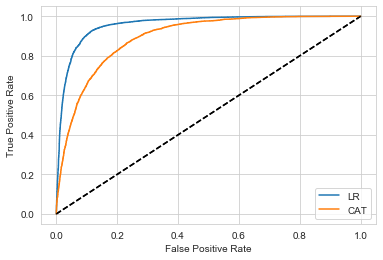

In [17]:
plt.figure()
for i, model in enumerate(classifier):
    fpr, tpr = test_roc(model, X_test, y_test)
    plt.plot(fpr, tpr, label=classifier_names[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

### A Voting Classifier of Catboost and Lightgbm Model

In [18]:
vcf = VotingClassifier(estimators=[('lr', lgm),('cat',cat)], voting='soft')
vcf.fit(X,y)
prediction = vcf.predict_proba(test.drop('Applicant_ID', axis =1))[:,1]

Learning rate set to 0.039622
0:	learn: 0.6667601	total: 105ms	remaining: 2m 37s
1:	learn: 0.6444197	total: 262ms	remaining: 3m 16s
2:	learn: 0.6240351	total: 379ms	remaining: 3m 9s
3:	learn: 0.6060258	total: 524ms	remaining: 3m 16s
4:	learn: 0.5890400	total: 630ms	remaining: 3m 8s
5:	learn: 0.5743362	total: 789ms	remaining: 3m 16s
6:	learn: 0.5610494	total: 900ms	remaining: 3m 12s
7:	learn: 0.5493150	total: 987ms	remaining: 3m 4s
8:	learn: 0.5386189	total: 1.09s	remaining: 3m 1s
9:	learn: 0.5293569	total: 1.25s	remaining: 3m 5s
10:	learn: 0.5212643	total: 1.34s	remaining: 3m
11:	learn: 0.5138993	total: 1.44s	remaining: 2m 58s
12:	learn: 0.5061706	total: 1.55s	remaining: 2m 57s
13:	learn: 0.4999301	total: 1.64s	remaining: 2m 54s
14:	learn: 0.4941331	total: 1.75s	remaining: 2m 53s
15:	learn: 0.4891628	total: 1.86s	remaining: 2m 52s
16:	learn: 0.4843339	total: 1.95s	remaining: 2m 49s
17:	learn: 0.4798713	total: 2.06s	remaining: 2m 49s
18:	learn: 0.4759475	total: 2.19s	remaining: 2m 50s
1

158:	learn: 0.4022603	total: 19.3s	remaining: 2m 42s
159:	learn: 0.4021620	total: 19.4s	remaining: 2m 42s
160:	learn: 0.4020656	total: 19.5s	remaining: 2m 42s
161:	learn: 0.4019985	total: 19.6s	remaining: 2m 41s
162:	learn: 0.4018909	total: 19.7s	remaining: 2m 41s
163:	learn: 0.4018221	total: 19.8s	remaining: 2m 41s
164:	learn: 0.4017341	total: 19.9s	remaining: 2m 40s
165:	learn: 0.4016412	total: 20s	remaining: 2m 40s
166:	learn: 0.4015699	total: 20.1s	remaining: 2m 40s
167:	learn: 0.4015105	total: 20.3s	remaining: 2m 40s
168:	learn: 0.4014331	total: 20.4s	remaining: 2m 40s
169:	learn: 0.4013346	total: 20.5s	remaining: 2m 40s
170:	learn: 0.4012205	total: 20.7s	remaining: 2m 40s
171:	learn: 0.4011553	total: 20.8s	remaining: 2m 40s
172:	learn: 0.4010556	total: 20.9s	remaining: 2m 40s
173:	learn: 0.4009536	total: 21s	remaining: 2m 40s
174:	learn: 0.4008595	total: 21.1s	remaining: 2m 40s
175:	learn: 0.4007573	total: 21.3s	remaining: 2m 39s
176:	learn: 0.4007021	total: 21.4s	remaining: 2m 3

314:	learn: 0.3907919	total: 36.3s	remaining: 2m 16s
315:	learn: 0.3907162	total: 36.5s	remaining: 2m 16s
316:	learn: 0.3906242	total: 36.6s	remaining: 2m 16s
317:	learn: 0.3905424	total: 36.7s	remaining: 2m 16s
318:	learn: 0.3904785	total: 36.8s	remaining: 2m 16s
319:	learn: 0.3904070	total: 36.9s	remaining: 2m 16s
320:	learn: 0.3903340	total: 37s	remaining: 2m 15s
321:	learn: 0.3902731	total: 37.1s	remaining: 2m 15s
322:	learn: 0.3902202	total: 37.2s	remaining: 2m 15s
323:	learn: 0.3901517	total: 37.3s	remaining: 2m 15s
324:	learn: 0.3900621	total: 37.4s	remaining: 2m 15s
325:	learn: 0.3899833	total: 37.5s	remaining: 2m 15s
326:	learn: 0.3899182	total: 37.6s	remaining: 2m 14s
327:	learn: 0.3898418	total: 37.7s	remaining: 2m 14s
328:	learn: 0.3897471	total: 37.8s	remaining: 2m 14s
329:	learn: 0.3896644	total: 37.9s	remaining: 2m 14s
330:	learn: 0.3895948	total: 38.1s	remaining: 2m 14s
331:	learn: 0.3895320	total: 38.2s	remaining: 2m 14s
332:	learn: 0.3894889	total: 38.3s	remaining: 2m

472:	learn: 0.3797641	total: 54.6s	remaining: 1m 58s
473:	learn: 0.3796739	total: 54.7s	remaining: 1m 58s
474:	learn: 0.3796122	total: 54.9s	remaining: 1m 58s
475:	learn: 0.3795529	total: 55s	remaining: 1m 58s
476:	learn: 0.3794651	total: 55.1s	remaining: 1m 58s
477:	learn: 0.3793861	total: 55.2s	remaining: 1m 58s
478:	learn: 0.3793025	total: 55.3s	remaining: 1m 57s
479:	learn: 0.3792142	total: 55.4s	remaining: 1m 57s
480:	learn: 0.3791402	total: 55.6s	remaining: 1m 57s
481:	learn: 0.3790835	total: 55.7s	remaining: 1m 57s
482:	learn: 0.3790151	total: 55.9s	remaining: 1m 57s
483:	learn: 0.3789511	total: 56s	remaining: 1m 57s
484:	learn: 0.3788961	total: 56.1s	remaining: 1m 57s
485:	learn: 0.3788138	total: 56.2s	remaining: 1m 57s
486:	learn: 0.3787075	total: 56.3s	remaining: 1m 57s
487:	learn: 0.3786497	total: 56.3s	remaining: 1m 56s
488:	learn: 0.3785918	total: 56.5s	remaining: 1m 56s
489:	learn: 0.3785752	total: 56.5s	remaining: 1m 56s
490:	learn: 0.3785054	total: 56.7s	remaining: 1m 5

628:	learn: 0.3698242	total: 1m 12s	remaining: 1m 40s
629:	learn: 0.3697673	total: 1m 12s	remaining: 1m 40s
630:	learn: 0.3696876	total: 1m 12s	remaining: 1m 40s
631:	learn: 0.3696825	total: 1m 12s	remaining: 1m 39s
632:	learn: 0.3696135	total: 1m 12s	remaining: 1m 39s
633:	learn: 0.3695585	total: 1m 12s	remaining: 1m 39s
634:	learn: 0.3694902	total: 1m 13s	remaining: 1m 39s
635:	learn: 0.3694359	total: 1m 13s	remaining: 1m 39s
636:	learn: 0.3693872	total: 1m 13s	remaining: 1m 39s
637:	learn: 0.3693322	total: 1m 13s	remaining: 1m 39s
638:	learn: 0.3693292	total: 1m 13s	remaining: 1m 39s
639:	learn: 0.3692464	total: 1m 13s	remaining: 1m 39s
640:	learn: 0.3691910	total: 1m 13s	remaining: 1m 38s
641:	learn: 0.3691262	total: 1m 13s	remaining: 1m 38s
642:	learn: 0.3690698	total: 1m 14s	remaining: 1m 38s
643:	learn: 0.3690186	total: 1m 14s	remaining: 1m 38s
644:	learn: 0.3689442	total: 1m 14s	remaining: 1m 38s
645:	learn: 0.3688776	total: 1m 14s	remaining: 1m 38s
646:	learn: 0.3688230	total:

781:	learn: 0.3615578	total: 1m 31s	remaining: 1m 23s
782:	learn: 0.3614876	total: 1m 31s	remaining: 1m 23s
783:	learn: 0.3614295	total: 1m 31s	remaining: 1m 23s
784:	learn: 0.3613628	total: 1m 31s	remaining: 1m 23s
785:	learn: 0.3613610	total: 1m 31s	remaining: 1m 23s
786:	learn: 0.3613033	total: 1m 31s	remaining: 1m 23s
787:	learn: 0.3612526	total: 1m 31s	remaining: 1m 22s
788:	learn: 0.3612065	total: 1m 31s	remaining: 1m 22s
789:	learn: 0.3611450	total: 1m 32s	remaining: 1m 22s
790:	learn: 0.3611026	total: 1m 32s	remaining: 1m 22s
791:	learn: 0.3610628	total: 1m 32s	remaining: 1m 22s
792:	learn: 0.3610362	total: 1m 32s	remaining: 1m 22s
793:	learn: 0.3609897	total: 1m 32s	remaining: 1m 22s
794:	learn: 0.3609301	total: 1m 32s	remaining: 1m 22s
795:	learn: 0.3608808	total: 1m 32s	remaining: 1m 22s
796:	learn: 0.3608283	total: 1m 32s	remaining: 1m 21s
797:	learn: 0.3607764	total: 1m 33s	remaining: 1m 21s
798:	learn: 0.3607047	total: 1m 33s	remaining: 1m 21s
799:	learn: 0.3606601	total:

935:	learn: 0.3535058	total: 1m 49s	remaining: 1m 5s
936:	learn: 0.3534515	total: 1m 49s	remaining: 1m 5s
937:	learn: 0.3534098	total: 1m 49s	remaining: 1m 5s
938:	learn: 0.3533516	total: 1m 49s	remaining: 1m 5s
939:	learn: 0.3532999	total: 1m 49s	remaining: 1m 5s
940:	learn: 0.3532500	total: 1m 50s	remaining: 1m 5s
941:	learn: 0.3532080	total: 1m 50s	remaining: 1m 5s
942:	learn: 0.3531615	total: 1m 50s	remaining: 1m 5s
943:	learn: 0.3531087	total: 1m 50s	remaining: 1m 5s
944:	learn: 0.3530428	total: 1m 50s	remaining: 1m 4s
945:	learn: 0.3530037	total: 1m 50s	remaining: 1m 4s
946:	learn: 0.3529556	total: 1m 50s	remaining: 1m 4s
947:	learn: 0.3529022	total: 1m 50s	remaining: 1m 4s
948:	learn: 0.3528460	total: 1m 50s	remaining: 1m 4s
949:	learn: 0.3527921	total: 1m 51s	remaining: 1m 4s
950:	learn: 0.3527495	total: 1m 51s	remaining: 1m 4s
951:	learn: 0.3526927	total: 1m 51s	remaining: 1m 4s
952:	learn: 0.3526512	total: 1m 51s	remaining: 1m 3s
953:	learn: 0.3525950	total: 1m 51s	remaining:

1092:	learn: 0.3457163	total: 2m 6s	remaining: 47.2s
1093:	learn: 0.3456739	total: 2m 7s	remaining: 47.1s
1094:	learn: 0.3456210	total: 2m 7s	remaining: 47s
1095:	learn: 0.3455768	total: 2m 7s	remaining: 46.9s
1096:	learn: 0.3455421	total: 2m 7s	remaining: 46.8s
1097:	learn: 0.3455402	total: 2m 7s	remaining: 46.6s
1098:	learn: 0.3454989	total: 2m 7s	remaining: 46.6s
1099:	learn: 0.3454385	total: 2m 7s	remaining: 46.4s
1100:	learn: 0.3453766	total: 2m 7s	remaining: 46.3s
1101:	learn: 0.3453231	total: 2m 8s	remaining: 46.2s
1102:	learn: 0.3452714	total: 2m 8s	remaining: 46.1s
1103:	learn: 0.3452241	total: 2m 8s	remaining: 46s
1104:	learn: 0.3451836	total: 2m 8s	remaining: 45.9s
1105:	learn: 0.3451363	total: 2m 8s	remaining: 45.7s
1106:	learn: 0.3451069	total: 2m 8s	remaining: 45.6s
1107:	learn: 0.3450499	total: 2m 8s	remaining: 45.5s
1108:	learn: 0.3450117	total: 2m 8s	remaining: 45.4s
1109:	learn: 0.3449419	total: 2m 8s	remaining: 45.3s
1110:	learn: 0.3448781	total: 2m 8s	remaining: 45.

1246:	learn: 0.3385417	total: 2m 25s	remaining: 29.5s
1247:	learn: 0.3384909	total: 2m 25s	remaining: 29.3s
1248:	learn: 0.3384458	total: 2m 25s	remaining: 29.2s
1249:	learn: 0.3383999	total: 2m 25s	remaining: 29.1s
1250:	learn: 0.3383377	total: 2m 25s	remaining: 29s
1251:	learn: 0.3382783	total: 2m 25s	remaining: 28.9s
1252:	learn: 0.3382329	total: 2m 25s	remaining: 28.8s
1253:	learn: 0.3381939	total: 2m 25s	remaining: 28.6s
1254:	learn: 0.3381489	total: 2m 26s	remaining: 28.5s
1255:	learn: 0.3381212	total: 2m 26s	remaining: 28.4s
1256:	learn: 0.3380751	total: 2m 26s	remaining: 28.3s
1257:	learn: 0.3380275	total: 2m 26s	remaining: 28.2s
1258:	learn: 0.3379657	total: 2m 26s	remaining: 28s
1259:	learn: 0.3379148	total: 2m 26s	remaining: 27.9s
1260:	learn: 0.3378601	total: 2m 26s	remaining: 27.8s
1261:	learn: 0.3378145	total: 2m 26s	remaining: 27.7s
1262:	learn: 0.3377982	total: 2m 26s	remaining: 27.6s
1263:	learn: 0.3377333	total: 2m 26s	remaining: 27.4s
1264:	learn: 0.3376860	total: 2m

1401:	learn: 0.3317361	total: 2m 42s	remaining: 11.4s
1402:	learn: 0.3316998	total: 2m 42s	remaining: 11.3s
1403:	learn: 0.3316638	total: 2m 43s	remaining: 11.1s
1404:	learn: 0.3316161	total: 2m 43s	remaining: 11s
1405:	learn: 0.3315646	total: 2m 43s	remaining: 10.9s
1406:	learn: 0.3315222	total: 2m 43s	remaining: 10.8s
1407:	learn: 0.3314823	total: 2m 43s	remaining: 10.7s
1408:	learn: 0.3314490	total: 2m 43s	remaining: 10.6s
1409:	learn: 0.3314113	total: 2m 43s	remaining: 10.4s
1410:	learn: 0.3313768	total: 2m 43s	remaining: 10.3s
1411:	learn: 0.3313249	total: 2m 43s	remaining: 10.2s
1412:	learn: 0.3312822	total: 2m 43s	remaining: 10.1s
1413:	learn: 0.3312427	total: 2m 44s	remaining: 9.98s
1414:	learn: 0.3311859	total: 2m 44s	remaining: 9.86s
1415:	learn: 0.3311327	total: 2m 44s	remaining: 9.75s
1416:	learn: 0.3310997	total: 2m 44s	remaining: 9.63s
1417:	learn: 0.3310412	total: 2m 44s	remaining: 9.52s
1418:	learn: 0.3310032	total: 2m 44s	remaining: 9.4s
1419:	learn: 0.3309569	total: 2

### Creating Prediction file

In [20]:
sub = pd.DataFrame({'Applicant_ID':test.Applicant_ID, 'default_status':prediction})

In [21]:
sub.to_csv('vcf_cat_lgb_submission.csv', index = False)

In [22]:
sub.describe()

,default_status
count,24000.000000
mean,0.232950
std,0.251935
min,0.000298
25%,0.029972
50%,0.131283
75%,0.363970
max,0.990218
